In [1]:
import os
import shutil

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

import torch
import torchvision
from torchvision.models import AlexNet

torchvision.disable_beta_transforms_warning();
import torchvision.transforms.v2 as t

from lightning import seed_everything

from captum.attr import Saliency, IntegratedGradients, NoiseTunnel
from captum.attr import visualization as viz

from typing import Callable, Any

from datamodules import ImagenetteDataModule
from hyperparameters import Hyperparameters

In [2]:
IMAGENETTE = Path.home() / "datasets" / "imagenette" 
CKPT_PATH = Path.cwd() / "trained_models" / "alexnet_pretrained_acc=0.9.ckpt"

experiment = Hyperparameters(
    task = "multiclass_classification",
    random_seed = 42,
    num_classes = 10,
    metrics = ["accuracy", "f1"],

    criterion = torch.nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    learning_rate = 1e-5,
    momentum = 0.9,
    weight_decay = 5e-4,
    #momentum=0,
    #weight_decay=0,

    batch_size = 128,
    grad_accum = 4,
    test_split = .3,
    transform = ["scale_[0,1]", "resize_256", "random_crop_224", "normalize", "hflip"],
    num_workers = 8,
)
seed_everything(experiment.random_seed)

alexnet_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale = True),
    t.Resize(size = (256, 256), antialias = True),
    t.RandomCrop(size = (224, 224), pad_if_needed = True),
    t.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

inverse_normalize = t.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

Seed set to 42


In [3]:
model = AlexNet(num_classes=10)

checkpoint_state_dict = torch.load(CKPT_PATH)["state_dict"]
state_dict = {key.removeprefix("model."):checkpoint_state_dict[key] for key in checkpoint_state_dict.keys() if "criterion" not in key} 
model.load_state_dict(state_dict)

model.eval()

datamodule = ImagenetteDataModule(IMAGENETTE, experiment, alexnet_transform)
datamodule.setup("fit")

torch.float32
tensor(0.)
tensor(1.)


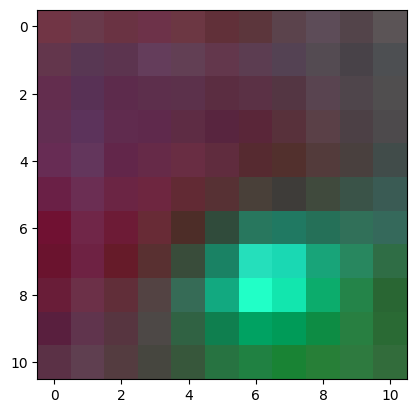

In [128]:
first_layer_weights = model.features[0].weight.detach()
num_kernels = model.features[0].out_channels

#kernel = first_layer_weights[0].permute(1, 2, 0)
##kernel = t.ToDtype(torch.float32, scale = True)(kernel)
#print(kernel.dtype)
#print(kernel.min())
#print(kernel.max())
#plt.imshow(kernel)
_, axes = plt.subplots(num_kernels // 16, 16)
for idx, ax in enumerate(axes.ravel()):
    kernel = first_layer_weights[idx].permute(1, 2, 0)
    kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
    ax.imshow(first_layer_weights[idx].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


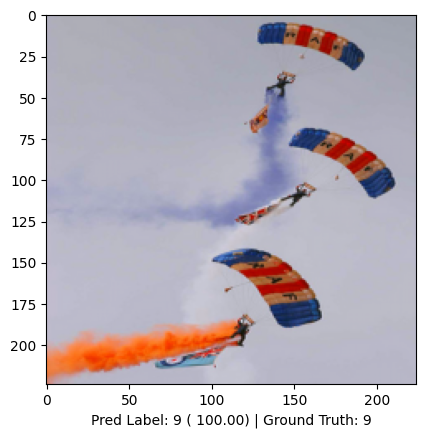

In [74]:
image_t, label = next(iter(datamodule.train_dataset))
image = inverse_normalize(image_t).permute(1, 2, 0).numpy()

image_t = image_t.unsqueeze(0)
image_t.requires_grad = True

pred = model(image_t)
pred_label = pred.argmax().item()
pred_prob = pred.softmax(1).squeeze()[pred_label].detach().item()

plt.imshow(image);
plt.xlabel(f"Pred Label: {pred_label} ({pred_prob * 100: .2f}) | Ground Truth: {label.item()}");

#print(pred_prob[pred_label].detach().item())

Approximation delta:  tensor([0.1354], dtype=torch.float64)


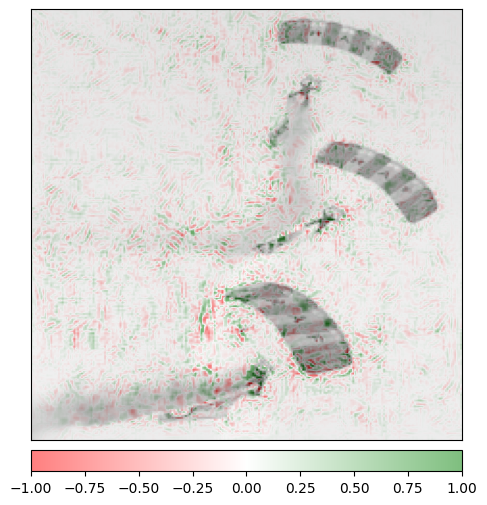

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [75]:
ig = IntegratedGradients(model)
attr_ig, delta = ig.attribute(
    inputs = image_t, 
    target = label.item(),
    baselines = torch.zeros_like(image_t),
    return_convergence_delta=True) 
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

viz.visualize_image_attr(attr=attr_ig, original_image=image, method="blended_heat_map", sign="all", show_colorbar=True)

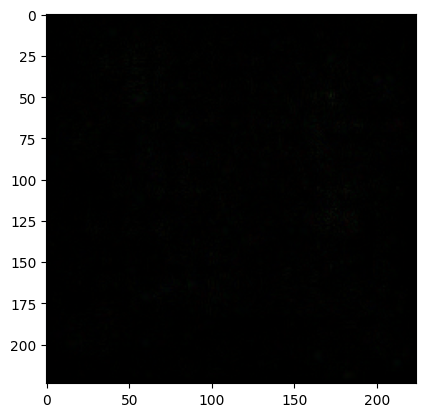

In [7]:
saliency = Saliency(model)
grads = saliency.attribute(
    inputs = image,
    target = label.item(),
)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
plt.imshow(grads)